In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np


warnings.filterwarnings(
    "ignore", 
    message="Could not infer format, so each element will be parsed individually.*"
)
# Load training (sample) and validation datasets
sample = pd.read_csv("airline_data_training.csv")
validation = pd.read_csv("airline_data_validation.csv")


### Check for Nulls and data describe

In [2]:
sample.describe()

,cum_bookings
count,4697.000000
mean,127.739408
std,157.038944
min,0.000000
25%,14.000000
50%,67.000000
75%,186.000000
max,799.000000


In [3]:
(sample
 .isnull()
 .sum()
)

departure_date    0
booking_date      0
cum_bookings      0
dtype: int64

In [4]:
validation.describe()

,cum_bookings,naive_fcst
count,210.000000,196.000000
mean,326.971429,423.548469
std,163.017066,149.231238
min,69.000000,215.083333
25%,180.500000,265.208333
50%,308.500000,421.291667
75%,475.000000,564.145833
max,652.000000,685.416667


In [5]:
(validation
 .isnull()
 .sum()
 )

departure_date     0
booking_date       0
cum_bookings       0
naive_fcst        14
dtype: int64

### Add finalDemand rows to dataset

In [9]:
def finalDemand(dataset):
    final_df = dataset.loc[dataset["DaysToDepart"] == pd.Timedelta("0 days"), ["departure_date", "cum_bookings"]]
    
    if final_df.empty:
        print("Warning: No rows found with DaysToDepart=0 days. Skipping final demand calculation.")
        dataset["Final_Demand"] = np.nan  # keep dataset intact but mark missing
        return dataset

    final_df = final_df.rename(columns={"cum_bookings": "Final_Demand"})
    merged_dataset = dataset.merge(final_df, on="departure_date", how="right")
    return merged_dataset


### Setting up Day of week for Day of week analysis

In [10]:
def dataProcessing(dataset, dtype):
    # Add day_of_week using 'departure_date'
    dataset = (
        dataset
        .assign(
            day_of_week=lambda df: pd.to_datetime(df['departure_date']).dt.day_name(),
            DaysToDepart=lambda df: pd.to_datetime(df['departure_date']) - pd.to_datetime(df['booking_date'])
        )
        .pipe(finalDemand)  # Add final demand for each departure
    )

    if dtype.lower() == 'sample':
        dataset = (
            dataset
            .assign(
                remDemand=lambda df: df["Final_Demand"] - df["cum_bookings"],
                rateBookings=lambda df: df["cum_bookings"] / df["Final_Demand"]
            )
            .loc[lambda df: df["DaysToDepart"] != pd.Timedelta("0 days")]  # keep only days prior to departure
        )
    
    return dataset


### Piping the sample dataframe through dataprocessing logic

In [11]:
sample = sample.pipe(dataProcessing, dtype='sample')

sample.head()

,departure_date,booking_date,cum_bookings,day_of_week,DaysToDepart,Final_Demand,remDemand,rateBookings
0,8/16/12,6/17/12,0,Thursday,60 days,257,257,0.000000
1,8/16/12,6/18/12,0,Thursday,59 days,257,257,0.000000
2,8/16/12,6/19/12,0,Thursday,58 days,257,257,0.000000
3,8/16/12,6/20/12,2,Thursday,57 days,257,255,0.007782
4,8/16/12,6/21/12,2,Thursday,56 days,257,255,0.007782


### Setting up error calculations for comparisons of approach later on

In [12]:
def absError(testcase, forecastType):

    
    # Calculate naive error as absolute difference from Final Demand
    testcase = testcase.assign(
        naiveError=lambda df: (df["naive_fcst"] - df["Final_Demand"]).abs()
    )
    naiveError = testcase["naiveError"].sum()
    
    # Branch logic depending on forecast type
    if forecastType.lower() == 'add':
        testcase = testcase.assign(
            addError=lambda df: (df["addForecast"] - df["Final_Demand"]).abs()
        )
        addError = testcase["addError"].sum()
        return addError, naiveError

    elif forecastType.lower() == 'multi':
        testcase = testcase.assign(
            multiError=lambda df: (df["multiForecast"] - df["Final_Demand"]).abs()
        )
        multiError = testcase["multiError"].sum()
        return multiError, naiveError


### Calculation of MASE metric

In [13]:
def findMASE(error, naive):
    
    mase = 0
    
    mase = round((error/naive), 4) * 100
    
    return mase
    

### Additive Forecast logic

In [14]:
def addForecast(sample, testcase, parameter):

    
    # Compute the forecasted remaining demand grouped as needed
    forecast = (
        sample
        .pipe(
            lambda df: df.groupby(["DaysToDepart", "day_of_week"])["remDemand"].mean()
            if parameter
            else df.groupby("DaysToDepart")["remDemand"].mean()
        )
        .reset_index()
    )
    
    # Merge testcase with the forecast and calculate the additive forecast in a chain
    testcase = (
        testcase
        .merge(forecast, on=["DaysToDepart", "day_of_week"] if parameter else ["DaysToDepart"], how="inner")
        .assign(addForecast=lambda df: df["cum_bookings"] + df["remDemand"])
    )
    
    # Create the results table
    additiveFcst = testcase.loc[:, ["departure_date", "booking_date", "day_of_week", "DaysToDepart", "addForecast"]]

    # Compute errors
    addError, naiveError = absError(testcase, 'add')
    mase = findMASE(addError, naiveError)
    
    return additiveFcst, mase


### Multiplicative forecast logic

In [15]:
def multiForecast(sample, testcase, dayOfWeek):

    
    # Compute the forecasted booking rates grouped as needed
    forecast = (
        sample
        .pipe(
            lambda df: df.groupby(["DaysToDepart", "day_of_week"])["rateBookings"].mean()
            if dayOfWeek
            else df.groupby("DaysToDepart")["rateBookings"].mean()
        )
        .reset_index()
    )
    
    # Merge testcase with the forecast and calculate the multiplicative forecast in a chain
    testcase = (
        testcase
        .merge(forecast, on=["DaysToDepart", "day_of_week"] if dayOfWeek else ["DaysToDepart"], how="inner")
        .assign(multiForecast=lambda df: df["cum_bookings"] / df["rateBookings"])  # calculate multi values
    )
    
    # a fraction of table is saved to create a results table of sorts later
    multiplicativeFcst = testcase.loc[:, ["departure_date", "booking_date", "day_of_week", "DaysToDepart", "multiForecast"]]

    # error calculation
    multiError, naiveError = absError(testcase, 'multi')
    
    # MASE calculation
    mase = findMASE(multiError, naiveError)
    
    return multiplicativeFcst, mase


### Structure all the forecast values into a single table

In [16]:
def resultTable(sample, testcase):


    # creating a MASE results table and a forecasts table
    dpAdd, maseDpAdd = addForecast(sample, testcase, False)
    dwAdd, maseDwAdd = addForecast(sample, testcase, True)
    dpMulti, maseDpMulti = multiForecast(sample, testcase, False)
    dwMulti, maseDwMulti = multiForecast(sample, testcase, True)

    # merging various forecast results into one table
    fcstResult = (
        dpAdd
        .merge(dwAdd, on=["day_of_week", "DaysToDepart", "departure_date", "booking_date"], how="inner")
        .merge(dpMulti, on=["day_of_week", "DaysToDepart", "departure_date", "booking_date"], how="inner")
        .merge(dwMulti, on=["day_of_week", "DaysToDepart", "departure_date", "booking_date"], how="inner")
        .round(0)  # rounding all forecast columns to 0 decimals
    )

    # adding all MASE scores into a table
    maseValues = (
        pd.DataFrame(
            columns=["Forecasts"],
            index=[
                "Additive - Days Prior",
                "Additive - Days Prior + Day of Week",
                "Multiplicative - Days Prior",
                "Multiplicative - Days Prior + Day of Week"
            ],
            data=[[maseDpAdd], [maseDwAdd], [maseDpMulti], [maseDwMulti]]
        )
    )

    return fcstResult, maseValues


In [ ]:
usecase = validation.pipe(dataProcessing, dtype='validation') # piping validation dataframe through dataprocessing logic

## Forecast and Save - time for results

In [19]:
Results, MASE = resultTable(sample, usecase)

In [ ]:
Results = Results.rename(columns={ ## Renaming fields for clairty
        "addForecast_x": "addByDaysPrior",
        "addForecast_y": "addByDayOfWeek",
        "multiForecast_x": "multiByDaysPrior",
        "multiForecast_y": "multiByDayOfWeek"
    })

In [21]:
print(
        "According to our analysis,",
        str(MASE["Forecasts"].idxmin()),
        "has the least MASE score at",
        str(MASE["Forecasts"].min()) + "%",
        "\n\nFor MASE scores of others, refer the below table:"
    )

print(MASE)

According to our analysis, Additive - Days Prior + Day of Week has the least MASE score at 64.4% 

For MASE scores of others, refer the below table:
                                           Forecasts
Additive - Days Prior                          83.52
Additive - Days Prior + Day of Week            64.40
Multiplicative - Days Prior                   157.88
Multiplicative - Days Prior + Day of Week     160.57


## Lets evaluate the performance of the best model

In [22]:
usecase = usecase.dropna()

### Annotate MASE on subplots - to compare Naive vs Best model (Additive - Days Prior + Day of Week  )

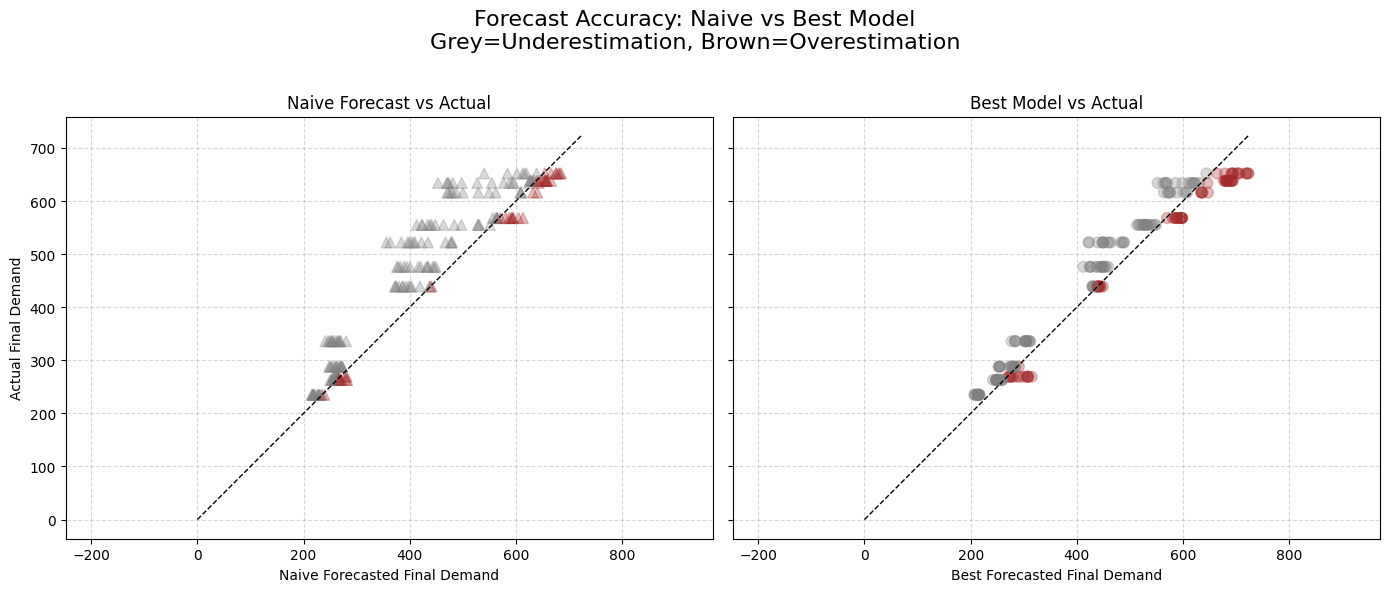

In [23]:
aligned_actual = usecase["Final_Demand"].reset_index(drop=True)
aligned_naive = usecase["naive_fcst"].reset_index(drop=True)
aligned_best = Results["addByDayOfWeek"].reset_index(drop=True)

max_val = max(aligned_actual.max(), aligned_naive.max(), aligned_best.max())

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

# Naive forecast subplot
axes[0].scatter(
    aligned_naive, aligned_actual,
    c=np.where(aligned_actual > aligned_naive, 'grey', 'brown'),
    alpha=0.3, s=60, marker='^'
)
axes[0].plot([0, max_val], [0, max_val], 'k--', lw=1)
axes[0].set_xlabel("Naive Forecasted Final Demand")
axes[0].set_ylabel("Actual Final Demand")
axes[0].set_title("Naive Forecast vs Actual")
axes[0].set_xlim(0, max_val)
axes[0].set_ylim(0, max_val)
axes[0].axis("equal")
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].grid(True, )

# Best model forecast subplot
axes[1].scatter(
    aligned_best, aligned_actual,
    c=np.where(aligned_actual > aligned_best, 'grey', 'brown'),
    alpha=0.3, s=60, marker='o'
)
axes[1].plot([0, max_val], [0, max_val], 'k--', lw=1)
axes[1].set_xlabel("Best Forecasted Final Demand")
axes[1].set_title("Best Model vs Actual")
axes[1].set_xlim(0, max_val)
axes[1].set_ylim(0, max_val)
axes[1].axis("equal")
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.suptitle(
    "Forecast Accuracy: Naive vs Best Model\nGrey=Underestimation, Brown=Overestimation",
    fontsize=16
)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Comments:  
» Naive model has more scattered away presence from the perfect line  
» Best Model is tightly grouped around the perfect line

### Absolute Error Distribution

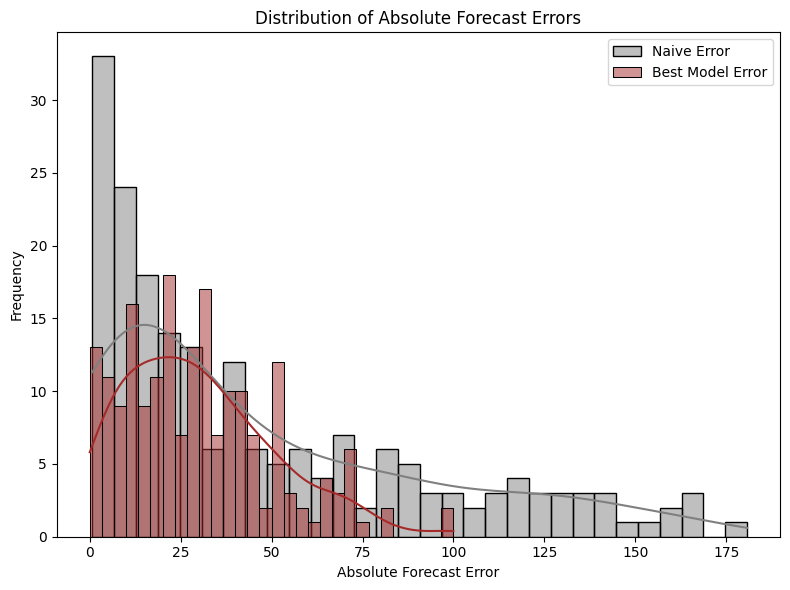

In [24]:
abs_naive_error = (aligned_naive - aligned_actual).abs()
abs_best_error = (aligned_best - aligned_actual).abs()

plt.figure(figsize=(8,6))
sns.histplot(abs_naive_error, bins=30, color='grey', kde=True, label="Naive Error")
sns.histplot(abs_best_error, bins=30, color='brown', kde=True, label="Best Model Error")
plt.xlabel("Absolute Forecast Error")
plt.ylabel("Frequency")
plt.title("Distribution of Absolute Forecast Errors")
plt.legend()
plt.tight_layout()
plt.show()


Comment:  
» Naive errors have a winder, longer tail : likely to produce large errors  
» Best Model(Additive - Days Prior + Day of Week) more concentrated towards the left

### Residuals Distribution

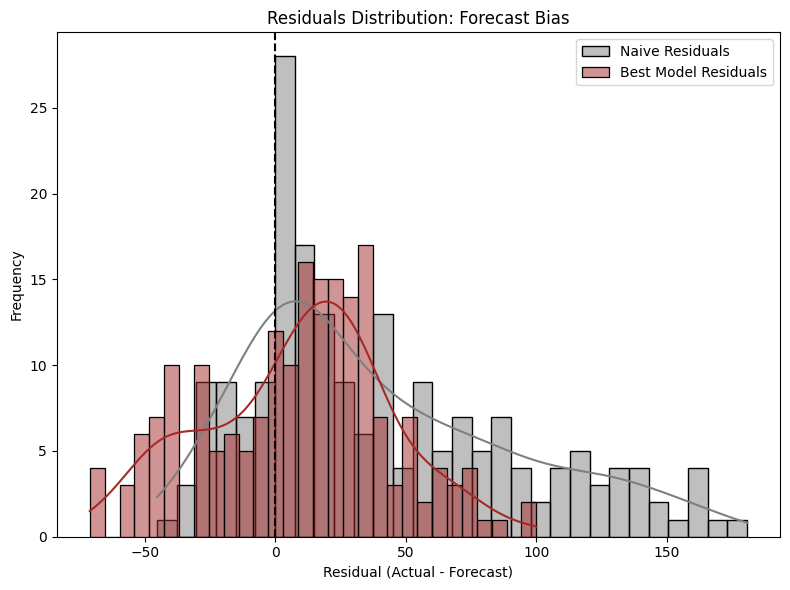

In [25]:
naive_residuals = aligned_actual - aligned_naive
best_residuals = aligned_actual - aligned_best

plt.figure(figsize=(8,6))
sns.histplot(naive_residuals, bins=30, color='grey', kde=True, label="Naive Residuals")
sns.histplot(best_residuals, bins=30, color='brown', kde=True, label="Best Model Residuals")
plt.axvline(0, color='k', linestyle='--')
plt.xlabel("Residual (Actual - Forecast)")
plt.ylabel("Frequency")
plt.title("Residuals Distribution: Forecast Bias")
plt.legend()
plt.tight_layout()
plt.show()


Comment:  
» **Naive is skewed right**: Naive forecasts often underestimate demand, resulting in positive residuals  
» **Best model - more centered**: Our best model(Additive - Days Prior + Day of Week) shows some bias but residuals are more symmetrically distributed around zero